# Recommender Systems Challenge, 2023/2024 @ PoliMi

# Introduction

## Problem Description
The application domain is book recommendation. The datasets contain interactions of users with books, in particular, if the user attributed to the book a rating of at least 4. The main goal of the competition is to discover which items (books) a user will interact with.

The datasets includes around 600k interactions, 13k users, 22k items (books).
The training-test split is done via random holdout, 80% training, 20% test.
The goal is to recommend a list of 10 potentially relevant items for each user.


## Datasets
All files are comma-separated (columns are separated with ',' ).

- **data_train.csv**:
Contains the training set, describing implicit preferences expressed by the users.
    - **user_id** : identifier of the user
    - **item_id** : identifier of the item (Book)
    - **data** : "1.0" if the user liked the book attributing it a rating of at least 4.


- **data_target_users_test.csv**:
Contains the ids of the users that should appear in your submission file.
The submission file should contain all and only these users.

- **sample_submission.csv**:
A sample submission file in the correct format: [user_id],[ordered list of recommended items].
Be careful with the spaces and be sure to recommend the correct number of items to every user.

# Requirements

The working environment and the required libraries are defined here.

In [1]:
# Import libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.sparse as sps # creation of sparse matrix
import matplotlib.pyplot as pyplot # plot

from tqdm import tqdm

from scipy.stats import uniform, loguniform
import optuna as op
import xgboost as xgb
from xgboost import XGBRanker

In [2]:
%load_ext Cython

# Data Preprocessing

In [3]:
# Handle the input file
input_file = open('Input/data_train.csv', 'r')
type(input_file)

_io.TextIOWrapper

In [4]:
# Build the dataframe from the input file
input_df = pd.read_csv(
    filepath_or_buffer=input_file,
    dtype={0:int, 1:int, 2:int},
    names=['user_id','item_id','data'],
    header=0
)

input_df.shape

(478730, 3)

In [5]:
# Show the first rows of the dataframe
input_df.head(n=10)

,user_id,item_id,data
0,1,7,1
1,1,15,1
2,1,16,1
3,1,133,1
4,1,161,1
5,1,187,1
6,1,205,1
7,1,222,1
8,1,237,1
9,1,354,1


In [6]:
mapped_id, original_id = pd.factorize(input_df["user_id"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

print("Unique UserID in the URM are {}".format(len(original_id)))

mapped_id, original_id = pd.factorize(input_df["item_id"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

print("Unique ItemID in the URM are {}".format(len(original_id)))

input_df["user_id"] = input_df["user_id"].map(user_original_ID_to_index)
input_df["item_id"] = input_df["item_id"].map(item_original_ID_to_index)

Unique UserID in the URM are 12638
Unique ItemID in the URM are 22222


In [7]:
input_df

,user_id,item_id,data
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
478725,12637,617,1
478726,12637,7533,1
478727,12637,17034,1
478728,12637,18422,1


# Matrix Conversion

In [8]:
n_users = len(user_original_ID_to_index)
n_items = len(item_original_ID_to_index)

# Evaluation of the recommender

In [9]:
# Import Evaluators
from Evaluation.Evaluator import EvaluatorHoldout
from sklearn.model_selection import train_test_split
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

In [10]:
seed = 28

In [11]:
(user_ids_training_validation, user_ids_test,
 item_ids_training_validation, item_ids_test,
 ratings_training_validation, ratings_test) = train_test_split(input_df.user_id,
                                                    input_df.item_id,
                                                    input_df.data,
                                                    test_size=0.15,
                                                    shuffle=True,
                                                    random_state=seed)

(user_ids_training, user_ids_validation,
 item_ids_training, item_ids_validation,
 ratings_training, ratings_validation) = train_test_split(user_ids_training_validation,
                                                          item_ids_training_validation,
                                                          ratings_training_validation,
                                                          test_size=0.15,
                                                          shuffle=True,
                                                          random_state=seed)

In [12]:
URM_all = sps.csr_matrix((input_df.data, (input_df.user_id, input_df.item_id)),
                           shape = (n_users, n_items))

URM_train = sps.csr_matrix((ratings_training, (user_ids_training, item_ids_training)),
                           shape = (n_users, n_items))

URM_validation = sps.csr_matrix((ratings_validation, (user_ids_validation, item_ids_validation)),
                           shape = (n_users, n_items))

URM_train_validation = sps.csr_matrix((ratings_training_validation, (user_ids_training_validation, item_ids_training_validation)),
                           shape = (n_users, n_items))

URM_test = sps.csr_matrix((ratings_test, (user_ids_test, item_ids_test)),
                           shape = (n_users, n_items))


In [13]:
# URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = train_test_split)
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = train_test_split)

In [14]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 3116 (24.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2748 (21.7%) Users that have less than 1 test interactions


## Best Recommenders after tuning

In [15]:
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
slime_train = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
slime_train.fit(l1_ratio=0.0702, alpha=0.000722, topK=692)

SLIMElasticNetRecommender: URM Detected 317 ( 2.5%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 189 ( 0.9%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22216/22222 [02:01<00:00, 182.23it/s]


In [16]:
slime_train_val = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train_validation)
slime_train_val.fit(l1_ratio=0.0702, alpha=0.000722, topK=692)

SLIMElasticNetRecommender: URM Detected 149 ( 1.2%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 75 ( 0.3%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22216/22222 [02:07<00:00, 174.63it/s]


In [17]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.Similarity.Compute_Similarity import Compute_Similarity
sim1 = Compute_Similarity(URM_train, shrink = 0, topK = 5, similarity = 'cosine').compute_similarity()
sim2 = Compute_Similarity(URM_train, shrink = 0.5, topK = 65, similarity = 'cosine').compute_similarity()
itemhybrid_train = ItemKNNSimilarityHybridRecommender(URM_train, sim1, sim2)
itemhybrid_train.fit(topK = 70, alpha = 0.65)

Similarity column 22222 (100.0%), 12040.67 column/sec. Elapsed time 1.85 sec
Similarity column 22222 (100.0%), 12068.97 column/sec. Elapsed time 1.84 sec
ItemKNNSimilarityHybridRecommender: URM Detected 317 ( 2.5%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 189 ( 0.9%) items with no interactions.


In [18]:
sim1_val = Compute_Similarity(URM_train_validation, shrink = 0, topK = 5, similarity = 'cosine').compute_similarity()
sim2_val = Compute_Similarity(URM_train_validation, shrink = 0.5, topK = 65, similarity = 'cosine').compute_similarity()
itemhybrid_train_val = ItemKNNSimilarityHybridRecommender(URM_train_validation, sim1_val, sim2_val)
itemhybrid_train_val.fit(topK = 70, alpha = 0.65)

Similarity column 22222 (100.0%), 11399.46 column/sec. Elapsed time 1.95 sec
Similarity column 22222 (100.0%), 11246.14 column/sec. Elapsed time 1.98 sec
ItemKNNSimilarityHybridRecommender: URM Detected 149 ( 1.2%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 75 ( 0.3%) items with no interactions.


In [19]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
rp3beta_train = RP3betaRecommender(URM_train)
rp3beta_train.fit(topK=25, alpha=0.253519, beta=0.209538, implicit=True, normalize_similarity=True)

RP3betaRecommender: URM Detected 317 ( 2.5%) users with no interactions.
RP3betaRecommender: URM Detected 189 ( 0.9%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 6899.51 column/sec. Elapsed time 3.22 sec


In [20]:
rp3beta_train_val = RP3betaRecommender(URM_train_validation)
rp3beta_train_val.fit(topK=25, alpha=0.253519, beta=0.209538, implicit=True, normalize_similarity=True)

RP3betaRecommender: URM Detected 149 ( 1.2%) users with no interactions.
RP3betaRecommender: URM Detected 75 ( 0.3%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 6499.22 column/sec. Elapsed time 3.42 sec


In [21]:
from Recommenders.ScoresHybridRecommender3 import ScoresHybridRecommender3
recommender_train = ScoresHybridRecommender3(URM_train, slime_train, itemhybrid_train, rp3beta_train)
recommender_train.fit(alpha=0.7, beta=0.05)

ScoresHybridRecommender3: URM Detected 317 ( 2.5%) users with no interactions.
ScoresHybridRecommender3: URM Detected 189 ( 0.9%) items with no interactions.


In [22]:
recommender_train_val = ScoresHybridRecommender3(URM_train_validation, slime_train_val, itemhybrid_train_val, rp3beta_train_val)
recommender_train_val.fit(alpha=0.7, beta=0.05)

ScoresHybridRecommender3: URM Detected 149 ( 1.2%) users with no interactions.
ScoresHybridRecommender3: URM Detected 75 ( 0.3%) items with no interactions.


In [23]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
itemknncf_train = ItemKNNCFRecommender(URM_train)
itemknncf_train.fit(shrink=15.47563, topK=12, similarity='dice')

ItemKNNCFRecommender: URM Detected 317 ( 2.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 189 ( 0.9%) items with no interactions.
Similarity column 22222 (100.0%), 12440.30 column/sec. Elapsed time 1.79 sec


In [24]:
itemknncf_train_val = ItemKNNCFRecommender(URM_train_validation)
itemknncf_train_val.fit(shrink=15.47563, topK=12, similarity='dice')

ItemKNNCFRecommender: URM Detected 149 ( 1.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 75 ( 0.3%) items with no interactions.
Similarity column 22222 (100.0%), 11584.14 column/sec. Elapsed time 1.92 sec


In [25]:
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
p3alpha_train = P3alphaRecommender(URM_train)
p3alpha_train.fit(topK=35, alpha=0.210046, implicit=True, normalize_similarity=True)

P3alphaRecommender: URM Detected 317 ( 2.5%) users with no interactions.
P3alphaRecommender: URM Detected 189 ( 0.9%) items with no interactions.
P3alphaRecommender: Similarity column 22222 (100.0%), 7248.30 column/sec. Elapsed time 3.07 sec


In [26]:
p3alpha_train_val = P3alphaRecommender(URM_train_validation)
p3alpha_train_val.fit(topK=35, alpha=0.210046, implicit=True, normalize_similarity=True)

P3alphaRecommender: URM Detected 149 ( 1.2%) users with no interactions.
P3alphaRecommender: URM Detected 75 ( 0.3%) items with no interactions.
P3alphaRecommender: Similarity column 22222 (100.0%), 6715.76 column/sec. Elapsed time 3.31 sec


In [27]:
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
ease_train = EASE_R_Recommender(URM_train)
ease_train.fit(topK=29, l2_norm=19)

EASE_R_Recommender: URM Detected 317 ( 2.5%) users with no interactions.
EASE_R_Recommender: URM Detected 189 ( 0.9%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 1.42 min


In [28]:
ease_train_val = EASE_R_Recommender(URM_train_validation)
ease_train_val.fit(topK=29, l2_norm=19)

EASE_R_Recommender: URM Detected 149 ( 1.2%) users with no interactions.
EASE_R_Recommender: URM Detected 75 ( 0.3%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 1.42 min


In [29]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
userknncf_train = UserKNNCFRecommender(URM_train)
userknncf_train.fit(shrink=1.432797, topK=329, feature_weighting="TF-IDF")

UserKNNCFRecommender: URM Detected 317 ( 2.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 189 ( 0.9%) items with no interactions.
Similarity column 12638 (100.0%), 11037.72 column/sec. Elapsed time 1.14 sec


In [30]:
userknncf_train_val = UserKNNCFRecommender(URM_train_validation)
userknncf_train_val.fit(shrink=1.432797, topK=329, feature_weighting="TF-IDF")

UserKNNCFRecommender: URM Detected 149 ( 1.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 75 ( 0.3%) items with no interactions.
Similarity column 12638 (100.0%), 10430.95 column/sec. Elapsed time 1.21 sec


In [31]:
evaluator_test.evaluateRecommender(recommender_train_val)

EvaluatorHoldout: Processed 9890 (100.0%) in 7.38 sec. Users per second: 1341


(       PRECISION PRECISION_RECALL_MIN_DEN   RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                     
 10      0.082629                  0.16539  0.14844  0.041089    0.082192   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.247575  0.144129  0.106163  0.489181      0.315889  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.782561          0.382814    0.782561       0.089112   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10           10.900641                   0.998882             0.254996   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                      

## XGBoost

In [32]:
candidate_generator_recommender = recommender_train

In [33]:
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["item_id"])
training_dataframe.index.name='user_id'

In [34]:
training_dataframe

,item_id
user_id,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
12633,NaN
12634,NaN
12635,NaN


In [35]:
cutoff = 30

for user_id in tqdm(range(n_users)):    
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "item_id"] = recommendations

100%|██████████████████████████████████████████████████████████████████████████| 12638/12638 [00:09<00:00, 1326.82it/s]


In [36]:
training_dataframe

,item_id
user_id,
0,"[674, 1449, 1, 587, 1585, 9, 2857, 2023, 2428,..."
1,"[2548, 887, 70, 49, 84, 3780, 89, 812, 83, 284..."
2,"[4809, 2229, 8304, 5375, 892, 244, 1750, 10350..."
3,"[227, 589, 812, 1569, 3708, 841, 2612, 678, 55..."
4,"[4316, 363, 2993, 4709, 950, 3456, 1262, 238, ..."
...,...
12633,"[2811, 2809, 11493, 2818, 587, 2817, 2807, 280..."
12634,"[3949, 120, 2810, 3937, 3958, 3943, 2815, 3, 1..."
12635,"[472, 257, 255, 285, 470, 248, 319, 2885, 1169..."


In [37]:
training_dataframe = training_dataframe.explode("item_id")
training_dataframe

,item_id
user_id,
0,674
0,1449
0,1
0,587
0,1585
...,...
12637,16588
12637,17033
12637,2744


In [38]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"user_id": URM_validation_coo.row,
                                        "item_id": URM_validation_coo.col})
correct_recommendations

,user_id,item_id
0,0,1
1,0,9
2,0,33
3,0,40
4,1,0
...,...,...
61033,12637,1116
61034,12637,1616
61035,12637,7828
61036,12637,10771


In [39]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['user_id','item_id'], how='left', indicator='Exist')
training_dataframe

,user_id,item_id,Exist
0,0,674,left_only
1,0,1449,left_only
2,0,1,both
3,0,587,left_only
4,0,1585,left_only
...,...,...,...
379135,12637,16588,left_only
379136,12637,17033,left_only
379137,12637,2744,left_only
379138,12637,10905,left_only


In [40]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,user_id,item_id,Label
0,0,674,False
1,0,1449,False
2,0,1,True
3,0,587,False
4,0,1585,False
...,...,...,...
379135,12637,16588,False
379136,12637,17033,False
379137,12637,2744,False
379138,12637,10905,False


In [41]:
other_algorithms = {
    "Hybrid": recommender_train,
    "ItemKNNCF": itemknncf_train,
    "P3alpha": p3alpha_train,
    "RP3beta": rp3beta_train,
    "SLIM-E": slime_train,
    "EASE_R": ease_train,
    "UserKNNCF": userknncf_train,
    "ItemHybrid": itemhybrid_train,
}

In [42]:
training_dataframe = training_dataframe.set_index('user_id')

for user_id in tqdm(range(n_users)):  
    for rec_label, rec_instance in other_algorithms.items():
        
        item_list = training_dataframe.loc[user_id, "item_id"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "user_id"})
training_dataframe

100%|███████████████████████████████████████████████████████████████████████████| 12638/12638 [00:44<00:00, 284.82it/s]


,user_id,item_id,Label,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid
0,0,674,False,0.508122,0.223716,0.344306,0.465662,0.521006,0.456216,12.136607,0.540051
1,0,1449,False,0.310282,0.316778,0.091752,0.301903,0.293551,0.209545,4.290180,0.586408
2,0,1,True,0.302873,0.122316,0.242278,0.337981,0.282726,0.151805,5.925041,0.409394
3,0,587,False,0.289070,0.119065,0.267032,0.347011,0.258572,0.156606,9.043689,0.426340
4,0,1585,False,0.252357,0.245874,0.077214,0.242833,0.247845,0.214018,3.686266,0.363144
...,...,...,...,...,...,...,...,...,...,...,...
379135,12637,16588,False,0.196922,0.293030,0.084471,0.128686,0.152119,0.109780,2.404347,1.165346
379136,12637,17033,False,0.190334,0.426360,0.072476,0.126338,0.128986,0.082370,1.326061,1.369183
379137,12637,2744,False,0.180462,0.179487,0.055610,0.083579,0.191169,0.132709,1.190214,0.514964
379138,12637,10905,False,0.180221,0.153846,0.076331,0.084185,0.156386,0.097264,2.346786,0.994105


In [43]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["item_id"].values.astype(int)]
training_dataframe

,user_id,item_id,Label,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity
0,0,674,False,0.508122,0.223716,0.344306,0.465662,0.521006,0.456216,12.136607,0.540051,326
1,0,1449,False,0.310282,0.316778,0.091752,0.301903,0.293551,0.209545,4.290180,0.586408,75
2,0,1,True,0.302873,0.122316,0.242278,0.337981,0.282726,0.151805,5.925041,0.409394,723
3,0,587,False,0.289070,0.119065,0.267032,0.347011,0.258572,0.156606,9.043689,0.426340,501
4,0,1585,False,0.252357,0.245874,0.077214,0.242833,0.247845,0.214018,3.686266,0.363144,77
...,...,...,...,...,...,...,...,...,...,...,...,...
379135,12637,16588,False,0.196922,0.293030,0.084471,0.128686,0.152119,0.109780,2.404347,1.165346,10
379136,12637,17033,False,0.190334,0.426360,0.072476,0.126338,0.128986,0.082370,1.326061,1.369183,4
379137,12637,2744,False,0.180462,0.179487,0.055610,0.083579,0.191169,0.132709,1.190214,0.514964,28
379138,12637,10905,False,0.180221,0.153846,0.076331,0.084185,0.156386,0.097264,2.346786,0.994105,12


In [44]:
user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)

training_dataframe['user_profile_len'] = user_popularity[training_dataframe["user_id"].values.astype(int)]
training_dataframe

,user_id,item_id,Label,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len
0,0,674,False,0.508122,0.223716,0.344306,0.465662,0.521006,0.456216,12.136607,0.540051,326,35
1,0,1449,False,0.310282,0.316778,0.091752,0.301903,0.293551,0.209545,4.290180,0.586408,75,35
2,0,1,True,0.302873,0.122316,0.242278,0.337981,0.282726,0.151805,5.925041,0.409394,723,35
3,0,587,False,0.289070,0.119065,0.267032,0.347011,0.258572,0.156606,9.043689,0.426340,501,35
4,0,1585,False,0.252357,0.245874,0.077214,0.242833,0.247845,0.214018,3.686266,0.363144,77,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379135,12637,16588,False,0.196922,0.293030,0.084471,0.128686,0.152119,0.109780,2.404347,1.165346,10,55
379136,12637,17033,False,0.190334,0.426360,0.072476,0.126338,0.128986,0.082370,1.326061,1.369183,4,55
379137,12637,2744,False,0.180462,0.179487,0.055610,0.083579,0.191169,0.132709,1.190214,0.514964,28,55
379138,12637,10905,False,0.180221,0.153846,0.076331,0.084185,0.156386,0.097264,2.346786,0.994105,12,55


## After adding features

In [45]:
# training_dataframe = training_dataframe.set_index('user_id')
# training_dataframe = training_dataframe.reset_index()
# training_dataframe = training_dataframe.rename(columns = {"index": 'user_id'})
# training_dataframe

In [46]:
training_dataframe = training_dataframe.sort_values("user_id").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,user_id,item_id,Label,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len
0,0,674,False,0.508122,0.223716,0.344306,0.465662,0.521006,0.456216,12.136607,0.540051,326,35
1,0,6738,False,0.101850,0.198392,0.000000,0.036131,0.120228,0.071500,2.209326,0.173162,43,35
2,0,678,False,0.102880,0.117431,0.047041,0.060458,0.104933,0.055712,0.595493,0.286255,244,35
3,0,319,False,0.104347,0.101791,0.000000,0.065001,0.108328,0.084960,3.074778,0.245348,500,35
4,0,1118,False,0.105063,0.182581,0.039011,0.140549,0.086860,0.068749,3.490444,0.182473,89,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379135,12637,17580,False,0.525413,0.819075,0.251382,0.361858,0.487582,0.276498,6.344635,1.872819,15,55
379136,12637,11426,True,0.546032,0.842474,0.273556,0.380068,0.454102,0.230880,4.014372,2.662877,12,55
379137,12637,10905,False,0.180221,0.153846,0.076331,0.084185,0.156386,0.097264,2.346786,0.994105,12,55
379138,12637,1616,True,0.298413,0.381325,0.109184,0.169906,0.304534,0.205726,4.443941,0.855254,42,55


In [47]:
groups = training_dataframe.groupby("user_id").size().values
groups

array([30, 30, 30, ..., 30, 30, 30], dtype=int64)

In [48]:
y_train = training_dataframe["Label"]
X_train_xgb = training_dataframe.drop(columns=["Label"])

In [49]:
X_train_xgb["user_id"] = X_train_xgb["user_id"].astype("category")
X_train_xgb["item_id"] = X_train_xgb["item_id"].astype("category")

In [50]:
n_estimators = 200
learning_rate = 0.15
reg_alpha = 30
reg_lambda = 0.1
max_depth = 3
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

colsample_bytree = 0.5
gamma = 5
min_child_weight = 5.0


XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      colsample_bytree = colsample_bytree,
                      gamma = gamma,
                      min_child_weight = min_child_weight,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )

In [51]:
XGB_model.fit(X_train_xgb,
          y_train,
          group=groups,
          verbose=True)


XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.5,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=5,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.15, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=3, max_leaves=0, min_child_weight=5.0, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=200,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [52]:
%matplotlib inline
from xgboost import plot_importance

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

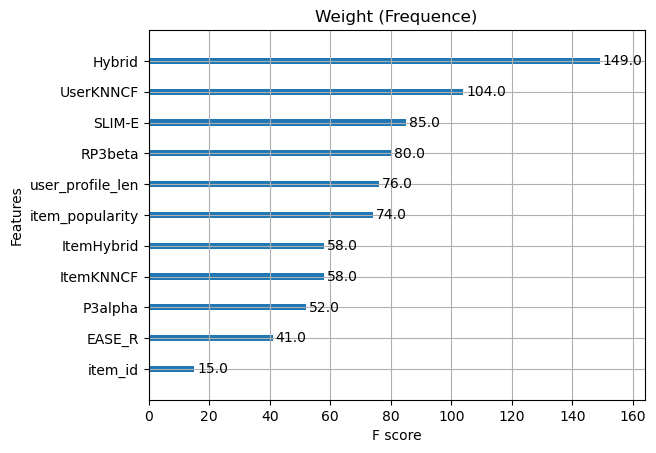

In [53]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

## Build test dataframe

In [54]:
users_to_recommend = np.unique(URM_test.tocoo().row)

user_recommendations_items = []
user_recommendations_user_id = []

for id in tqdm(users_to_recommend):
    # getting the recommendations
    recommendations = recommender_train_val.recommend(user_id_array=id, remove_seen_flag=True, cutoff=cutoff)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([id]*len(recommendations))
    
test_dataframe = pd.DataFrame({"user_id":user_recommendations_user_id, "item_id":user_recommendations_items})
test_dataframe

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:07<00:00, 1331.47it/s]


,user_id,item_id
0,0,674
1,0,587
2,0,1585
3,0,1449
4,0,2755
...,...,...
296695,12637,2744
296696,12637,696
296697,12637,694
296698,12637,10900


In [55]:
other_algorithms_train_validation = {
    "Hybrid": recommender_train_val,
    "ItemKNNCF": itemknncf_train_val,
    "P3alpha": p3alpha_train_val,
    "RP3beta": rp3beta_train_val,
    "SLIM-E": slime_train_val,
    "EASE_R": ease_train_val,
    "UserKNNCF": userknncf_train_val,
    "ItemHybrid": itemhybrid_train_val,
}

In [56]:
test_dataframe = test_dataframe.set_index('user_id')

for user_id in tqdm(users_to_recommend):       
    for rec_label, rec_instance in other_algorithms_train_validation.items():
        
        item_list = test_dataframe.loc[user_id, "item_id"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        test_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

test_dataframe = test_dataframe.reset_index()
test_dataframe = test_dataframe.rename(columns = {"index": "user_id"})
test_dataframe

100%|█████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:36<00:00, 274.12it/s]


,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid
0,0,674,0.707127,0.476774,0.449333,0.665007,0.691155,0.490226,21.360912,1.141336
1,0,587,0.542202,0.364388,0.407392,0.585519,0.503546,0.479448,18.574888,0.866801
2,0,1585,0.352939,0.498560,0.078392,0.285449,0.345402,0.287270,8.803205,0.795905
3,0,1449,0.316864,0.320451,0.089741,0.212910,0.321710,0.223213,9.058813,0.768792
4,0,2755,0.263381,0.250000,0.093403,0.127471,0.291533,0.250040,5.904123,0.548794
...,...,...,...,...,...,...,...,...,...,...
296695,12637,2744,0.209180,0.219780,0.057413,0.085192,0.225546,0.153618,1.683679,0.599996
296696,12637,696,0.195658,0.288068,0.000000,0.000000,0.229638,0.100994,10.766883,0.698231
296697,12637,694,0.185977,0.217336,0.000000,0.091446,0.182398,0.060041,11.149442,0.708739
296698,12637,10900,0.185239,0.658782,0.131640,0.177300,0.090301,0.192275,5.961126,1.554053


In [57]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train_validation).indptr)

test_dataframe['item_popularity'] = item_popularity[test_dataframe["item_id"].values.astype(int)]
test_dataframe

,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity
0,0,674,0.707127,0.476774,0.449333,0.665007,0.691155,0.490226,21.360912,1.141336,377
1,0,587,0.542202,0.364388,0.407392,0.585519,0.503546,0.479448,18.574888,0.866801,601
2,0,1585,0.352939,0.498560,0.078392,0.285449,0.345402,0.287270,8.803205,0.795905,86
3,0,1449,0.316864,0.320451,0.089741,0.212910,0.321710,0.223213,9.058813,0.768792,97
4,0,2755,0.263381,0.250000,0.093403,0.127471,0.291533,0.250040,5.904123,0.548794,124
...,...,...,...,...,...,...,...,...,...,...,...
296695,12637,2744,0.209180,0.219780,0.057413,0.085192,0.225546,0.153618,1.683679,0.599996,34
296696,12637,696,0.195658,0.288068,0.000000,0.000000,0.229638,0.100994,10.766883,0.698231,91
296697,12637,694,0.185977,0.217336,0.000000,0.091446,0.182398,0.060041,11.149442,0.708739,127
296698,12637,10900,0.185239,0.658782,0.131640,0.177300,0.090301,0.192275,5.961126,1.554053,21


In [58]:
user_popularity = np.ediff1d(sps.csr_matrix(URM_train_validation).indptr)

test_dataframe['user_profile_len'] = user_popularity[test_dataframe["user_id"].values.astype(int)]
test_dataframe

,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len
0,0,674,0.707127,0.476774,0.449333,0.665007,0.691155,0.490226,21.360912,1.141336,377,39
1,0,587,0.542202,0.364388,0.407392,0.585519,0.503546,0.479448,18.574888,0.866801,601,39
2,0,1585,0.352939,0.498560,0.078392,0.285449,0.345402,0.287270,8.803205,0.795905,86,39
3,0,1449,0.316864,0.320451,0.089741,0.212910,0.321710,0.223213,9.058813,0.768792,97,39
4,0,2755,0.263381,0.250000,0.093403,0.127471,0.291533,0.250040,5.904123,0.548794,124,39
...,...,...,...,...,...,...,...,...,...,...,...,...
296695,12637,2744,0.209180,0.219780,0.057413,0.085192,0.225546,0.153618,1.683679,0.599996,34,62
296696,12637,696,0.195658,0.288068,0.000000,0.000000,0.229638,0.100994,10.766883,0.698231,91,62
296697,12637,694,0.185977,0.217336,0.000000,0.091446,0.182398,0.060041,11.149442,0.708739,127,62
296698,12637,10900,0.185239,0.658782,0.131640,0.177300,0.090301,0.192275,5.961126,1.554053,21,62


In [59]:
test_dataframe = test_dataframe.sort_values("user_id").reset_index()
test_dataframe.drop(columns = ['index'], inplace=True)
test_dataframe

,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len
0,0,674,0.707127,0.476774,0.449333,0.665007,0.691155,0.490226,21.360912,1.141336,377,39
1,0,6738,0.107049,0.254388,0.000000,0.038405,0.113017,0.155223,7.214179,0.366711,56,39
2,0,13840,0.108641,0.177604,0.021308,0.040576,0.120783,0.034449,2.142048,0.278974,21,39
3,0,3708,0.110809,0.151803,0.042367,0.059408,0.109397,0.129144,2.924329,0.387581,184,39
4,0,6184,0.112612,0.214719,0.022975,0.071083,0.104831,0.033368,1.733873,0.429200,28,39
...,...,...,...,...,...,...,...,...,...,...,...,...
296695,12637,9567,0.558236,0.891048,0.198555,0.357706,0.507336,0.358740,11.200864,2.273499,38,62
296696,12637,16591,0.579754,1.214878,0.306634,0.443415,0.443400,0.327396,5.272201,3.170400,11,62
296697,12637,10900,0.185239,0.658782,0.131640,0.177300,0.090301,0.192275,5.961126,1.554053,21,62
296698,12637,17033,0.354163,0.874667,0.131159,0.333195,0.211675,0.172596,2.464640,2.453839,5,62


## Predict!

In [60]:
X = test_dataframe

In [61]:
predictions = XGB_model.predict(X)
predictions

array([ 1.4802898 , -0.53629655, -1.2226856 , ...,  0.2665368 ,
        0.79159147, -0.28422442], dtype=float32)

In [62]:
xgb_reranked = test_dataframe.copy()
xgb_reranked['rating_xgb'] = pd.Series(predictions, index=xgb_reranked.index)
xgb_reranked

,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len,rating_xgb
0,0,674,0.707127,0.476774,0.449333,0.665007,0.691155,0.490226,21.360912,1.141336,377,39,1.480290
1,0,6738,0.107049,0.254388,0.000000,0.038405,0.113017,0.155223,7.214179,0.366711,56,39,-0.536297
2,0,13840,0.108641,0.177604,0.021308,0.040576,0.120783,0.034449,2.142048,0.278974,21,39,-1.222686
3,0,3708,0.110809,0.151803,0.042367,0.059408,0.109397,0.129144,2.924329,0.387581,184,39,-0.732782
4,0,6184,0.112612,0.214719,0.022975,0.071083,0.104831,0.033368,1.733873,0.429200,28,39,-0.983123
...,...,...,...,...,...,...,...,...,...,...,...,...,...
296695,12637,9567,0.558236,0.891048,0.198555,0.357706,0.507336,0.358740,11.200864,2.273499,38,62,1.196706
296696,12637,16591,0.579754,1.214878,0.306634,0.443415,0.443400,0.327396,5.272201,3.170400,11,62,1.172932
296697,12637,10900,0.185239,0.658782,0.131640,0.177300,0.090301,0.192275,5.961126,1.554053,21,62,0.266537
296698,12637,17033,0.354163,0.874667,0.131159,0.333195,0.211675,0.172596,2.464640,2.453839,5,62,0.791591


In [63]:
xgb_reranked = xgb_reranked.sort_values(['user_id','rating_xgb'], ascending=[True, False])
xgb_reranked

,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len,rating_xgb
0,0,674,0.707127,0.476774,0.449333,0.665007,0.691155,0.490226,21.360912,1.141336,377,39,1.480290
18,0,587,0.542202,0.364388,0.407392,0.585519,0.503546,0.479448,18.574888,0.866801,601,39,1.397479
19,0,1585,0.352939,0.498560,0.078392,0.285449,0.345402,0.287270,8.803205,0.795905,86,39,1.082579
20,0,1449,0.316864,0.320451,0.089741,0.212910,0.321710,0.223213,9.058813,0.768792,97,39,0.882250
21,0,2755,0.263381,0.250000,0.093403,0.127471,0.291533,0.250040,5.904123,0.548794,124,39,0.765565
...,...,...,...,...,...,...,...,...,...,...,...,...,...
296679,12637,2744,0.209180,0.219780,0.057413,0.085192,0.225546,0.153618,1.683679,0.599996,34,62,-0.039425
296675,12637,694,0.185977,0.217336,0.000000,0.091446,0.182398,0.060041,11.149442,0.708739,127,62,-0.058888
296678,12637,1130,0.214198,0.187846,0.000000,0.052502,0.261149,0.134764,4.455251,0.365369,436,62,-0.082728
296680,12637,696,0.195658,0.288068,0.000000,0.000000,0.229638,0.100994,10.766883,0.698231,91,62,-0.180584


In [64]:
def list_recommendations(target_users, recommender):
    recommendations_list = []
    
    for id in target_users:
        recommendations_per_user = recommender.recommend(user_id_array = id, remove_seen_flag=True, cutoff=10)
        recommendations_list.append(recommendations_per_user)
        
    return recommendations_list

def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

# recommendations_list is the Python list of recommendations for each user in urm_test
def evaluate_recommender_MAP_from_rec_list(urm_test, recommendations_list, cutoff):
    target_users = np.unique(urm_test.tocoo().row)
    
    cumulative_AP = 0.0
    num_eval = 0
        
    for i in range(0, len(target_users)):
        relevant_items = urm_test.indices[urm_test.indptr[target_users[i]]:urm_test.indptr[target_users[i]+1]]
        
        if len(relevant_items)>0:
            recommended_items = recommendations_list[i]
            
            num_eval+=1
            
            cumulative_AP += AP(recommended_items, relevant_items)
            
    MAP = cumulative_AP / num_eval
    
    return MAP

In [65]:
user_recommendations = []

for user_id in tqdm(users_to_recommend):    
    user_recommendations.append(recommender_train_val.recommend(user_id, cutoff = 10))

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:07<00:00, 1333.41it/s]


In [66]:
user_recommendations_boosted = []

for id in tqdm(users_to_recommend):
    user_recommendations_boosted.append(xgb_reranked.loc[xgb_reranked['user_id'] == id].item_id.values[:10].tolist())

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3867.92it/s]


In [67]:
xgb_changed_item_count = 0

for i in range(len(user_recommendations)):
    default_items = user_recommendations[i]
    xgb_reranked_items = user_recommendations_boosted[i]
    
    xgb_new_items = list(set(xgb_reranked_items) - set(default_items))
    
    xgb_changed_item_count = xgb_changed_item_count + len(xgb_new_items)

n_users_to_recommend = len(users_to_recommend)
n_recommended_items = n_users_to_recommend * 10

print("XGBoost changed {} items, {:.2f}% of total".format(xgb_changed_item_count, xgb_changed_item_count/n_recommended_items * 100))

XGBoost changed 17452 items, 17.65% of total


In [68]:
print("Hybrid: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations, 10)))
print("XGBoost: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)))

Hybrid: 0.08219185888881989
XGBoost: 0.08363971719272263


In [69]:
best_MAP = 0
best_n_est = 0
best_lr = 0
best_alpha = 0
best_lambda = 0
best_colsample = 0
best_gamma = 0
best_min_weight = 0

In [70]:
res = evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)

In [71]:
res = evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)

if res > best_MAP:
    best_MAP = res

    best_n_est = n_estimators
    best_lr = learning_rate
    best_alpha = reg_alpha
    best_lambda = reg_lambda
    best_colsample = colsample_bytree
    best_gamma = gamma
    best_min_weight = min_child_weight

## Change parameters?

In [292]:
objective = "pairwise"
use_user_profile = False
random_seed = None

n_estimators = 300
learning_rate = 0.2
reg_alpha = 80
reg_lambda = 0.1
colsample_bytree = 0.7
gamma = 5
min_child_weight = 5.0


XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = 3,
                      max_leaves = 0,
                      grow_policy = "depthwise",
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = "gbtree",
                      enable_categorical = True,
                      colsample_bytree = colsample_bytree,
                      gamma = gamma,
                      min_child_weight = min_child_weight,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      
                     )

In [293]:
XGB_model.fit(X_train_xgb,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.7,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=5,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.2, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=3, max_leaves=0, min_child_weight=5.0, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=300,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

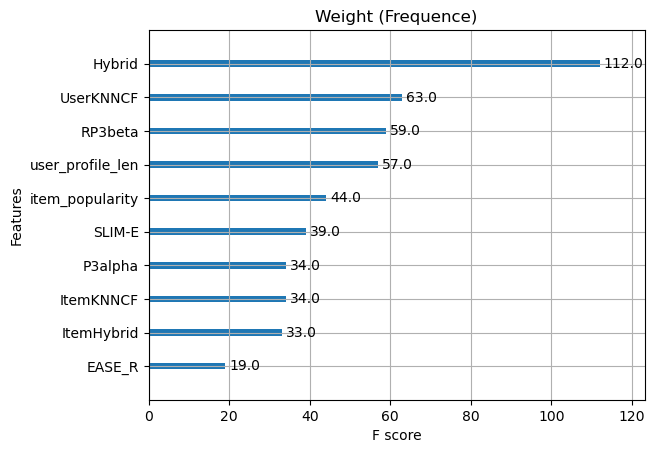

In [294]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [295]:
X = test_dataframe

In [296]:
predictions = XGB_model.predict(X)
xgb_reranked = test_dataframe.copy()
xgb_reranked['rating_xgb'] = pd.Series(predictions, index=xgb_reranked.index)
xgb_reranked = xgb_reranked.sort_values(['user_id','rating_xgb'], ascending=[True, False])

In [297]:
user_recommendations = []

for user_id in tqdm(users_to_recommend):    
    user_recommendations.append(recommender_train_val.recommend(user_id, cutoff = 10))

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:07<00:00, 1342.38it/s]


In [298]:
user_recommendations_boosted = []

for id in tqdm(users_to_recommend):
    user_recommendations_boosted.append(xgb_reranked.loc[xgb_reranked['user_id'] == id].item_id.values[:10].tolist())

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3993.78it/s]


In [299]:
xgb_changed_item_count = 0

for i in range(len(user_recommendations)):
    default_items = user_recommendations[i]
    xgb_reranked_items = user_recommendations_boosted[i]
    
    xgb_new_items = list(set(xgb_reranked_items) - set(default_items))
    
    xgb_changed_item_count = xgb_changed_item_count + len(xgb_new_items)

n_users_to_recommend = len(users_to_recommend)
n_recommended_items = n_users_to_recommend * 10

print("XGBoost changed {} items, {:.2f}% of total".format(xgb_changed_item_count, xgb_changed_item_count/n_recommended_items * 100))

XGBoost changed 17972 items, 18.17% of total


In [300]:
print("Hybrid: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations, 10)))
print("XGBoost: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)))

Hybrid: 0.08219185888881989
XGBoost: 0.08320414036958801


In [301]:
res = evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)

if res > best_MAP:
    print("Improvement! Previous best MAP = {}， ".format(best_MAP) + "Now = {}".format(res))
    best_MAP = res

    best_n_est = n_estimators
    best_lr = learning_rate
    best_alpha = reg_alpha
    best_lambda = reg_lambda
    best_colsample = colsample_bytree
    best_gamma = gamma
    best_min_weight = min_child_weight
else:
    print("No improvement")

No improvement


In [302]:
print("Best parameters for MAP {}".format(best_MAP))
print("n_estimators = {}".format(best_n_est))
print("learning_rate = {}".format(best_lr))
print("reg_alpha = {}".format(best_alpha))
print("reg_lambda = {}".format(best_lambda))
print("colsample_bytree = {}".format(best_colsample))
print("gamma = {}".format(best_gamma))
print("min_child_weight = {}".format(best_min_weight))

Best parameters for MAP 0.08393144769142344
n_estimators = 300
learning_rate = 0.2
reg_alpha = 30
reg_lambda = 0.1
colsample_bytree = 0.7
gamma = 5
min_child_weight = 5.0


## Tuning!

In [304]:
def objective(trial):
       
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.35)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 50)
    reg_lambda = trial.suggest_float("reg_lambda", 0.05, 0.5)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.3, 1)
    gamma = trial.suggest_int("gamma", 2, 10)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    
    objective = "pairwise"
    use_user_profile = False
    random_seed = None

    XGB_model = XGBRanker(objective='rank:{}'.format(objective),
        n_estimators = int(n_estimators),
        random_state = random_seed,
        learning_rate = learning_rate,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        max_depth = 3,
        max_leaves = 0,
        grow_policy = "depthwise",
        verbosity = 0, # 2 if self.verbose else 0,
        booster = "gbtree",
        enable_categorical = True,
        colsample_bytree = colsample_bytree,
        gamma = gamma,
        min_child_weight = min_child_weight,
        tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      
    )

    XGB_model.fit(X_train_xgb,
          y_train,
          group=groups,
          verbose=True)

    X = test_dataframe

    predictions = XGB_model.predict(X)
    xgb_reranked = test_dataframe.copy()
    xgb_reranked['rating_xgb'] = pd.Series(predictions, index=xgb_reranked.index)
    xgb_reranked = xgb_reranked.sort_values(['user_id','rating_xgb'], ascending=[True, False])

    user_recommendations_boosted = []

    for id in tqdm(users_to_recommend):
        user_recommendations_boosted.append(xgb_reranked.loc[xgb_reranked['user_id'] == id].item_id.values[:10].tolist())

    res = evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)
       
    return res

In [305]:
best_params = {
    'n_estimators': 300,
    'learning_rate' : 0.2,
    'reg_alpha' : 30,
    'reg_lambda' : 0.1,
    'colsample_bytree' : 0.7,
    'gamma' : 5,
    'min_child_weight' : 5.0,
}

In [306]:
study = op.create_study(direction="maximize")
study.enqueue_trial(best_params)
study.optimize(objective, n_trials=5000)

[I 2024-01-10 08:08:54,226] A new study created in memory with name: no-name-ef1b2cde-0d06-4aea-988d-152d0b49f82e
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3727.53it/s]
[I 2024-01-10 08:09:00,022] Trial 0 finished with value: 0.08393144769142344 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'reg_alpha': 30, 'reg_lambda': 0.1, 'colsample_bytree': 0.7, 'gamma': 5, 'min_child_weight': 5}. Best is trial 0 with value: 0.08393144769142344.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3972.77it/s]
[I 2024-01-10 08:09:05,636] Trial 1 finished with value: 0.08262146089664547 and parameters: {'n_estimators': 213, 'learning_rate': 0.031065108225069554, 'reg_alpha': 50, 'reg_lambda': 0.16148875435179122, 'colsample_bytree': 0.45071775392630903, 'gamma': 10, 'min_child_weight': 10}. Best is trial 0 with value: 0.08393144769142344.
100%|████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3978.80it/s]
[I 2024-01-10 08:13:30,303] Trial 36 finished with value: 0.08369061662413521 and parameters: {'n_estimators': 261, 'learning_rate': 0.17605376013676263, 'reg_alpha': 42, 'reg_lambda': 0.1706814865292536, 'colsample_bytree': 0.7570163156068569, 'gamma': 2, 'min_child_weight': 2}. Best is trial 0 with value: 0.08393144769142344.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3908.55it/s]
[I 2024-01-10 08:13:40,107] Trial 37 finished with value: 0.08382789657637385 and parameters: {'n_estimators': 835, 'learning_rate': 0.1342725338110739, 'reg_alpha': 46, 'reg_lambda': 0.28426094056273654, 'colsample_bytree': 0.8873398192503137, 'gamma': 6, 'min_child_weight': 6}. Best is trial 0 with value: 0.08393144769142344.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3945.24it/s]
[I 2024-01-10 08:18:39,932] Trial 72 finished with value: 0.0838109570608004 and parameters: {'n_estimators': 850, 'learning_rate': 0.1502677744546833, 'reg_alpha': 27, 'reg_lambda': 0.09498069681778967, 'colsample_bytree': 0.7852689751526718, 'gamma': 5, 'min_child_weight': 1}. Best is trial 69 with value: 0.08401618518620417.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3929.33it/s]
[I 2024-01-10 08:18:47,763] Trial 73 finished with value: 0.08330900821737496 and parameters: {'n_estimators': 722, 'learning_rate': 0.1567156536821503, 'reg_alpha': 30, 'reg_lambda': 0.12758146127322254, 'colsample_bytree': 0.7061402112131269, 'gamma': 4, 'min_child_weight': 3}. Best is trial 69 with value: 0.08401618518620417.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3996.57it/s]
[I 2024-01-10 08:23:13,852] Trial 108 finished with value: 0.08357320012133973 and parameters: {'n_estimators': 847, 'learning_rate': 0.17666905806036795, 'reg_alpha': 34, 'reg_lambda': 0.09061145393060772, 'colsample_bytree': 0.7405928736153171, 'gamma': 5, 'min_child_weight': 3}. Best is trial 69 with value: 0.08401618518620417.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3946.72it/s]
[I 2024-01-10 08:23:20,391] Trial 109 finished with value: 0.08355342185557871 and parameters: {'n_estimators': 341, 'learning_rate': 0.14612458042620607, 'reg_alpha': 47, 'reg_lambda': 0.19824930943348887, 'colsample_bytree': 0.9167818882224018, 'gamma': 2, 'min_child_weight': 1}. Best is trial 69 with value: 0.08401618518620417.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3978.11it/s]
[I 2024-01-10 08:27:13,426] Trial 144 finished with value: 0.08352183092182303 and parameters: {'n_estimators': 292, 'learning_rate': 0.1905831947294115, 'reg_alpha': 43, 'reg_lambda': 0.10336168040304056, 'colsample_bytree': 0.8591012855369042, 'gamma': 4, 'min_child_weight': 7}. Best is trial 113 with value: 0.0841535710528076.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3941.55it/s]
[I 2024-01-10 08:27:19,303] Trial 145 finished with value: 0.08381035233626803 and parameters: {'n_estimators': 260, 'learning_rate': 0.17368957418020442, 'reg_alpha': 40, 'reg_lambda': 0.08905312039156249, 'colsample_bytree': 0.8054499962332456, 'gamma': 5, 'min_child_weight': 6}. Best is trial 113 with value: 0.0841535710528076.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3986.86it/s]
[I 2024-01-10 08:31:11,523] Trial 180 finished with value: 0.08384263414949127 and parameters: {'n_estimators': 377, 'learning_rate': 0.1658910311036711, 'reg_alpha': 33, 'reg_lambda': 0.1441651388931098, 'colsample_bytree': 0.9012071615067008, 'gamma': 4, 'min_child_weight': 7}. Best is trial 113 with value: 0.0841535710528076.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3952.56it/s]
[I 2024-01-10 08:31:18,567] Trial 181 finished with value: 0.08348168918636598 and parameters: {'n_estimators': 405, 'learning_rate': 0.18010276095043098, 'reg_alpha': 34, 'reg_lambda': 0.1576605158899621, 'colsample_bytree': 0.9190425374758913, 'gamma': 3, 'min_child_weight': 6}. Best is trial 113 with value: 0.0841535710528076.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3940.51it/s]
[I 2024-01-10 08:34:55,319] Trial 216 finished with value: 0.08375838295004163 and parameters: {'n_estimators': 265, 'learning_rate': 0.15533690512842493, 'reg_alpha': 40, 'reg_lambda': 0.19799583401511917, 'colsample_bytree': 0.8386541979291274, 'gamma': 3, 'min_child_weight': 7}. Best is trial 215 with value: 0.0841945713760917.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3935.66it/s]
[I 2024-01-10 08:35:01,518] Trial 217 finished with value: 0.0839618388568024 and parameters: {'n_estimators': 288, 'learning_rate': 0.16279544769754523, 'reg_alpha': 40, 'reg_lambda': 0.11931203726265863, 'colsample_bytree': 0.823754327039788, 'gamma': 3, 'min_child_weight': 8}. Best is trial 215 with value: 0.0841945713760917.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3994.41it/s]
[I 2024-01-10 08:38:43,084] Trial 252 finished with value: 0.08376057449531112 and parameters: {'n_estimators': 334, 'learning_rate': 0.15938175308810915, 'reg_alpha': 40, 'reg_lambda': 0.10994983878220468, 'colsample_bytree': 0.956418373664095, 'gamma': 3, 'min_child_weight': 8}. Best is trial 215 with value: 0.0841945713760917.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3926.27it/s]
[I 2024-01-10 08:38:49,289] Trial 253 finished with value: 0.08361555096423455 and parameters: {'n_estimators': 280, 'learning_rate': 0.18363960204787222, 'reg_alpha': 36, 'reg_lambda': 0.41710170796046075, 'colsample_bytree': 0.9176454064001297, 'gamma': 3, 'min_child_weight': 7}. Best is trial 215 with value: 0.0841945713760917.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3939.22it/s]
[I 2024-01-10 08:42:33,103] Trial 288 finished with value: 0.08329054692318416 and parameters: {'n_estimators': 223, 'learning_rate': 0.2040160571725958, 'reg_alpha': 40, 'reg_lambda': 0.11416919933117706, 'colsample_bytree': 0.32716668579719316, 'gamma': 4, 'min_child_weight': 7}. Best is trial 215 with value: 0.0841945713760917.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3953.43it/s]
[I 2024-01-10 08:42:39,165] Trial 289 finished with value: 0.0837316904123742 and parameters: {'n_estimators': 268, 'learning_rate': 0.1610550577912742, 'reg_alpha': 38, 'reg_lambda': 0.12128379199305371, 'colsample_bytree': 0.8425333200957669, 'gamma': 4, 'min_child_weight': 9}. Best is trial 215 with value: 0.0841945713760917.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3939.30it/s]
[I 2024-01-10 08:46:20,752] Trial 324 finished with value: 0.08395890049743428 and parameters: {'n_estimators': 528, 'learning_rate': 0.22165188988050624, 'reg_alpha': 39, 'reg_lambda': 0.14776437133216722, 'colsample_bytree': 0.8105810521211245, 'gamma': 3, 'min_child_weight': 6}. Best is trial 215 with value: 0.0841945713760917.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3942.13it/s]
[I 2024-01-10 08:46:27,412] Trial 325 finished with value: 0.0835059994946935 and parameters: {'n_estimators': 367, 'learning_rate': 0.16586965908453682, 'reg_alpha': 44, 'reg_lambda': 0.1357980475327854, 'colsample_bytree': 0.594137406482765, 'gamma': 3, 'min_child_weight': 5}. Best is trial 215 with value: 0.0841945713760917.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3728.88it/s]
[I 2024-01-10 08:50:14,292] Trial 360 finished with value: 0.08368132130113023 and parameters: {'n_estimators': 316, 'learning_rate': 0.21493188093150428, 'reg_alpha': 44, 'reg_lambda': 0.1345655913504253, 'colsample_bytree': 0.907426027538015, 'gamma': 4, 'min_child_weight': 7}. Best is trial 215 with value: 0.0841945713760917.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3961.35it/s]
[I 2024-01-10 08:50:20,300] Trial 361 finished with value: 0.08392707557126862 and parameters: {'n_estimators': 278, 'learning_rate': 0.20332583962975062, 'reg_alpha': 41, 'reg_lambda': 0.2528172971352409, 'colsample_bytree': 0.8757179293078596, 'gamma': 3, 'min_child_weight': 6}. Best is trial 215 with value: 0.0841945713760917.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3852.12it/s]
[I 2024-01-10 08:53:49,382] Trial 396 finished with value: 0.08347280909798663 and parameters: {'n_estimators': 315, 'learning_rate': 0.28703833935661693, 'reg_alpha': 43, 'reg_lambda': 0.08633807852790853, 'colsample_bytree': 0.6280014872399259, 'gamma': 2, 'min_child_weight': 5}. Best is trial 215 with value: 0.0841945713760917.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3958.22it/s]
[I 2024-01-10 08:53:55,510] Trial 397 finished with value: 0.08392684509766138 and parameters: {'n_estimators': 333, 'learning_rate': 0.2786298397997592, 'reg_alpha': 42, 'reg_lambda': 0.3373493100873612, 'colsample_bytree': 0.8236144297820751, 'gamma': 3, 'min_child_weight': 6}. Best is trial 215 with value: 0.0841945713760917.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3813.34it/s]
[I 2024-01-10 08:57:24,136] Trial 432 finished with value: 0.08340684014777294 and parameters: {'n_estimators': 400, 'learning_rate': 0.26987448523853824, 'reg_alpha': 45, 'reg_lambda': 0.3679623540486066, 'colsample_bytree': 0.8909717918168999, 'gamma': 4, 'min_child_weight': 9}. Best is trial 416 with value: 0.08419871701910711.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3941.00it/s]
[I 2024-01-10 08:57:29,206] Trial 433 finished with value: 0.08314912967115438 and parameters: {'n_estimators': 280, 'learning_rate': 0.2732661653195513, 'reg_alpha': 34, 'reg_lambda': 0.34641623504052627, 'colsample_bytree': 0.4113013370192242, 'gamma': 3, 'min_child_weight': 6}. Best is trial 416 with value: 0.08419871701910711.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3966.34it/s]
[I 2024-01-10 09:02:40,363] Trial 468 finished with value: 0.08339458251843569 and parameters: {'n_estimators': 688, 'learning_rate': 0.32946609664444715, 'reg_alpha': 30, 'reg_lambda': 0.28609239811096204, 'colsample_bytree': 0.8378396853780214, 'gamma': 2, 'min_child_weight': 4}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3926.75it/s]
[I 2024-01-10 09:02:48,175] Trial 469 finished with value: 0.08363989853047149 and parameters: {'n_estimators': 635, 'learning_rate': 0.3122773605573534, 'reg_alpha': 28, 'reg_lambda': 0.35169655171463454, 'colsample_bytree': 0.5142197234812005, 'gamma': 3, 'min_child_weight': 4}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3811.78it/s]
[I 2024-01-10 09:07:17,908] Trial 504 finished with value: 0.08372847061248928 and parameters: {'n_estimators': 310, 'learning_rate': 0.2646321726786188, 'reg_alpha': 32, 'reg_lambda': 0.10238742633782451, 'colsample_bytree': 0.908347137857781, 'gamma': 2, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3928.63it/s]
[I 2024-01-10 09:07:23,886] Trial 505 finished with value: 0.0838148919577942 and parameters: {'n_estimators': 301, 'learning_rate': 0.28347704696451037, 'reg_alpha': 31, 'reg_lambda': 0.11193788967767818, 'colsample_bytree': 0.9089190786609114, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3804.05it/s]
[I 2024-01-10 09:11:21,960] Trial 540 finished with value: 0.08395443461154056 and parameters: {'n_estimators': 745, 'learning_rate': 0.2918868026342857, 'reg_alpha': 42, 'reg_lambda': 0.24702011412420805, 'colsample_bytree': 0.8095962112970474, 'gamma': 4, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3935.06it/s]
[I 2024-01-10 09:11:27,632] Trial 541 finished with value: 0.08355673034202625 and parameters: {'n_estimators': 216, 'learning_rate': 0.2011734980530569, 'reg_alpha': 34, 'reg_lambda': 0.30138402994312874, 'colsample_bytree': 0.9399152344010242, 'gamma': 3, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3930.09it/s]
[I 2024-01-10 09:15:22,057] Trial 576 finished with value: 0.08381399085773683 and parameters: {'n_estimators': 698, 'learning_rate': 0.1895018500256372, 'reg_alpha': 40, 'reg_lambda': 0.33389161495716907, 'colsample_bytree': 0.8168069789270935, 'gamma': 4, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3929.25it/s]
[I 2024-01-10 09:15:28,430] Trial 577 finished with value: 0.08385294096105261 and parameters: {'n_estimators': 334, 'learning_rate': 0.22637218823010644, 'reg_alpha': 36, 'reg_lambda': 0.18076418969429459, 'colsample_bytree': 0.9561282682186798, 'gamma': 3, 'min_child_weight': 8}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3788.47it/s]
[I 2024-01-10 09:19:31,479] Trial 612 finished with value: 0.08319660315817143 and parameters: {'n_estimators': 257, 'learning_rate': 0.2519025487601938, 'reg_alpha': 40, 'reg_lambda': 0.19801405027436828, 'colsample_bytree': 0.6185212997697362, 'gamma': 6, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3980.99it/s]
[I 2024-01-10 09:19:37,802] Trial 613 finished with value: 0.0837814503090302 and parameters: {'n_estimators': 284, 'learning_rate': 0.16369722358653446, 'reg_alpha': 38, 'reg_lambda': 0.48526165233499596, 'colsample_bytree': 0.9739307125515477, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3829.28it/s]
[I 2024-01-10 09:23:36,584] Trial 648 finished with value: 0.08384820971604744 and parameters: {'n_estimators': 409, 'learning_rate': 0.2898369707080849, 'reg_alpha': 41, 'reg_lambda': 0.0973923361574495, 'colsample_bytree': 0.8141807095079403, 'gamma': 4, 'min_child_weight': 10}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3966.12it/s]
[I 2024-01-10 09:23:42,964] Trial 649 finished with value: 0.0840381523700741 and parameters: {'n_estimators': 322, 'learning_rate': 0.18896718561151796, 'reg_alpha': 43, 'reg_lambda': 0.11861543421135182, 'colsample_bytree': 0.9711645845119644, 'gamma': 3, 'min_child_weight': 7}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3962.43it/s]
[I 2024-01-10 09:27:12,105] Trial 684 finished with value: 0.08351750889285786 and parameters: {'n_estimators': 317, 'learning_rate': 0.3020152964825565, 'reg_alpha': 43, 'reg_lambda': 0.19676949229278135, 'colsample_bytree': 0.5952935661291648, 'gamma': 3, 'min_child_weight': 10}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3957.84it/s]
[I 2024-01-10 09:27:18,105] Trial 685 finished with value: 0.08352113456512411 and parameters: {'n_estimators': 250, 'learning_rate': 0.1270375116054443, 'reg_alpha': 42, 'reg_lambda': 0.11346753939301268, 'colsample_bytree': 0.49161930032020207, 'gamma': 2, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3828.24it/s]
[I 2024-01-10 09:30:47,634] Trial 720 finished with value: 0.08358827702803379 and parameters: {'n_estimators': 316, 'learning_rate': 0.22654359758552794, 'reg_alpha': 42, 'reg_lambda': 0.1693223081314121, 'colsample_bytree': 0.7689265996860056, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3957.67it/s]
[I 2024-01-10 09:30:53,158] Trial 721 finished with value: 0.08369887554036676 and parameters: {'n_estimators': 259, 'learning_rate': 0.32069406650579135, 'reg_alpha': 37, 'reg_lambda': 0.24855663686922336, 'colsample_bytree': 0.7106513616510806, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3739.23it/s]
[I 2024-01-10 09:34:44,024] Trial 756 finished with value: 0.0835534994603015 and parameters: {'n_estimators': 294, 'learning_rate': 0.14040940723205256, 'reg_alpha': 38, 'reg_lambda': 0.12037920143411854, 'colsample_bytree': 0.5383686203284964, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3976.34it/s]
[I 2024-01-10 09:34:49,404] Trial 757 finished with value: 0.08346897925556009 and parameters: {'n_estimators': 345, 'learning_rate': 0.2700600613351553, 'reg_alpha': 41, 'reg_lambda': 0.13943648623575217, 'colsample_bytree': 0.4562464702862321, 'gamma': 3, 'min_child_weight': 10}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3959.27it/s]
[I 2024-01-10 09:38:45,612] Trial 792 finished with value: 0.0835293555865591 and parameters: {'n_estimators': 337, 'learning_rate': 0.3316378777004135, 'reg_alpha': 44, 'reg_lambda': 0.4831319191334937, 'colsample_bytree': 0.4918573289424601, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3971.31it/s]
[I 2024-01-10 09:38:51,780] Trial 793 finished with value: 0.08366213381206859 and parameters: {'n_estimators': 314, 'learning_rate': 0.2122444926321878, 'reg_alpha': 41, 'reg_lambda': 0.10350302366973213, 'colsample_bytree': 0.7324695345486476, 'gamma': 3, 'min_child_weight': 8}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3814.03it/s]
[I 2024-01-10 09:42:46,060] Trial 828 finished with value: 0.08357077071456959 and parameters: {'n_estimators': 280, 'learning_rate': 0.29926502020027734, 'reg_alpha': 40, 'reg_lambda': 0.41652936383036454, 'colsample_bytree': 0.7071665979020465, 'gamma': 3, 'min_child_weight': 7}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 4000.54it/s]
[I 2024-01-10 09:42:51,755] Trial 829 finished with value: 0.08340127145960036 and parameters: {'n_estimators': 291, 'learning_rate': 0.23146129894140907, 'reg_alpha': 37, 'reg_lambda': 0.14962351703139523, 'colsample_bytree': 0.4823935194280498, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3783.07it/s]
[I 2024-01-10 09:46:44,440] Trial 864 finished with value: 0.08343213349171424 and parameters: {'n_estimators': 315, 'learning_rate': 0.1513049239155563, 'reg_alpha': 36, 'reg_lambda': 0.146841930374223, 'colsample_bytree': 0.9037450129126244, 'gamma': 3, 'min_child_weight': 4}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3955.06it/s]
[I 2024-01-10 09:46:54,633] Trial 865 finished with value: 0.08369047068140041 and parameters: {'n_estimators': 716, 'learning_rate': 0.07811136998533465, 'reg_alpha': 39, 'reg_lambda': 0.4392749781610067, 'colsample_bytree': 0.7909099382892432, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3945.24it/s]
[I 2024-01-10 09:50:44,516] Trial 900 finished with value: 0.08332064618717189 and parameters: {'n_estimators': 366, 'learning_rate': 0.09183793859719469, 'reg_alpha': 39, 'reg_lambda': 0.11168181491712655, 'colsample_bytree': 0.36720447793100136, 'gamma': 4, 'min_child_weight': 4}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3938.20it/s]
[I 2024-01-10 09:50:51,932] Trial 901 finished with value: 0.08322183079126112 and parameters: {'n_estimators': 725, 'learning_rate': 0.17557159716571724, 'reg_alpha': 45, 'reg_lambda': 0.3168634527207372, 'colsample_bytree': 0.8203590645370229, 'gamma': 10, 'min_child_weight': 9}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3784.02it/s]
[I 2024-01-10 09:54:50,212] Trial 936 finished with value: 0.08380674567508886 and parameters: {'n_estimators': 224, 'learning_rate': 0.22256982782733306, 'reg_alpha': 39, 'reg_lambda': 0.10795770663407092, 'colsample_bytree': 0.6740542526734742, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3915.86it/s]
[I 2024-01-10 09:54:55,431] Trial 937 finished with value: 0.08347672963317034 and parameters: {'n_estimators': 241, 'learning_rate': 0.2552259326607156, 'reg_alpha': 42, 'reg_lambda': 0.13764613510225215, 'colsample_bytree': 0.301178221041002, 'gamma': 4, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3778.32it/s]
[I 2024-01-10 09:58:54,436] Trial 972 finished with value: 0.08352140065665593 and parameters: {'n_estimators': 271, 'learning_rate': 0.24756021999192768, 'reg_alpha': 40, 'reg_lambda': 0.30066648959018955, 'colsample_bytree': 0.8632245213362209, 'gamma': 4, 'min_child_weight': 9}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3981.04it/s]
[I 2024-01-10 09:58:59,949] Trial 973 finished with value: 0.08380384914329712 and parameters: {'n_estimators': 306, 'learning_rate': 0.23025806393076878, 'reg_alpha': 37, 'reg_lambda': 0.31672004227833045, 'colsample_bytree': 0.7820200420215044, 'gamma': 4, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3885.09it/s]
[I 2024-01-10 10:02:59,109] Trial 1008 finished with value: 0.08389680592399476 and parameters: {'n_estimators': 373, 'learning_rate': 0.13892356152092666, 'reg_alpha': 29, 'reg_lambda': 0.15203849652793894, 'colsample_bytree': 0.9138993701081533, 'gamma': 3, 'min_child_weight': 10}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3931.95it/s]
[I 2024-01-10 10:03:06,342] Trial 1009 finished with value: 0.08348966796769992 and parameters: {'n_estimators': 680, 'learning_rate': 0.2874914488909558, 'reg_alpha': 36, 'reg_lambda': 0.22666416008067383, 'colsample_bytree': 0.7116322225870267, 'gamma': 3, 'min_child_weight': 8}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3763.86it/s]
[I 2024-01-10 10:07:02,139] Trial 1044 finished with value: 0.08377763253561905 and parameters: {'n_estimators': 618, 'learning_rate': 0.14325349004687987, 'reg_alpha': 45, 'reg_lambda': 0.110434001485047, 'colsample_bytree': 0.7403069755312472, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 4002.43it/s]
[I 2024-01-10 10:07:09,317] Trial 1045 finished with value: 0.08399169912881438 and parameters: {'n_estimators': 422, 'learning_rate': 0.1684417677175693, 'reg_alpha': 31, 'reg_lambda': 0.21671014803056693, 'colsample_bytree': 0.5463123592951726, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3803.73it/s]
[I 2024-01-10 10:11:03,464] Trial 1080 finished with value: 0.0836451006740559 and parameters: {'n_estimators': 314, 'learning_rate': 0.18300997031652208, 'reg_alpha': 42, 'reg_lambda': 0.4951273618294098, 'colsample_bytree': 0.973113974357654, 'gamma': 3, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3990.72it/s]
[I 2024-01-10 10:11:09,983] Trial 1081 finished with value: 0.08373453943237005 and parameters: {'n_estimators': 360, 'learning_rate': 0.1610041701980474, 'reg_alpha': 40, 'reg_lambda': 0.08094477122007238, 'colsample_bytree': 0.6032773956880991, 'gamma': 4, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3965.66it/s]
[I 2024-01-10 10:15:47,651] Trial 1116 finished with value: 0.08379602929719976 and parameters: {'n_estimators': 660, 'learning_rate': 0.12883636572809518, 'reg_alpha': 44, 'reg_lambda': 0.24018676308956743, 'colsample_bytree': 0.9658912558935977, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3977.17it/s]
[I 2024-01-10 10:15:59,867] Trial 1117 finished with value: 0.08352403678113536 and parameters: {'n_estimators': 689, 'learning_rate': 0.03768890315965126, 'reg_alpha': 38, 'reg_lambda': 0.07064246164598306, 'colsample_bytree': 0.8456338946664232, 'gamma': 2, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3786.46it/s]
[I 2024-01-10 10:20:07,876] Trial 1152 finished with value: 0.08341390571226798 and parameters: {'n_estimators': 340, 'learning_rate': 0.15253139486919096, 'reg_alpha': 26, 'reg_lambda': 0.1482822035738094, 'colsample_bytree': 0.5923499452273155, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3942.11it/s]
[I 2024-01-10 10:20:15,243] Trial 1153 finished with value: 0.08324775962139319 and parameters: {'n_estimators': 690, 'learning_rate': 0.30653663776249473, 'reg_alpha': 42, 'reg_lambda': 0.12997674252716138, 'colsample_bytree': 0.8465741200556911, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3810.41it/s]
[I 2024-01-10 10:24:16,072] Trial 1188 finished with value: 0.08371650725694893 and parameters: {'n_estimators': 352, 'learning_rate': 0.18122881774402616, 'reg_alpha': 44, 'reg_lambda': 0.13987172554331267, 'colsample_bytree': 0.9245865562370206, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3926.76it/s]
[I 2024-01-10 10:24:22,009] Trial 1189 finished with value: 0.08353734742408343 and parameters: {'n_estimators': 273, 'learning_rate': 0.22859967371962514, 'reg_alpha': 42, 'reg_lambda': 0.4514674223796634, 'colsample_bytree': 0.9735452780979814, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3962.71it/s]
[I 2024-01-10 10:28:46,420] Trial 1224 finished with value: 0.08382035022562355 and parameters: {'n_estimators': 520, 'learning_rate': 0.0982733120262964, 'reg_alpha': 39, 'reg_lambda': 0.474013252040781, 'colsample_bytree': 0.8608593933371906, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3968.35it/s]
[I 2024-01-10 10:28:54,895] Trial 1225 finished with value: 0.08400296066634694 and parameters: {'n_estimators': 498, 'learning_rate': 0.09472046983619059, 'reg_alpha': 40, 'reg_lambda': 0.4611419657785037, 'colsample_bytree': 0.864013197653865, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3794.70it/s]
[I 2024-01-10 10:33:21,845] Trial 1260 finished with value: 0.08366022442381416 and parameters: {'n_estimators': 427, 'learning_rate': 0.06013645590912679, 'reg_alpha': 44, 'reg_lambda': 0.47787299585039567, 'colsample_bytree': 0.6236995528277169, 'gamma': 3, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3918.96it/s]
[I 2024-01-10 10:33:29,855] Trial 1261 finished with value: 0.08347056832132524 and parameters: {'n_estimators': 562, 'learning_rate': 0.22445440625126667, 'reg_alpha': 26, 'reg_lambda': 0.3773347314335811, 'colsample_bytree': 0.9043791994054796, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3781.59it/s]
[I 2024-01-10 10:38:06,439] Trial 1296 finished with value: 0.08218755810004753 and parameters: {'n_estimators': 590, 'learning_rate': 0.13112966354152203, 'reg_alpha': 14, 'reg_lambda': 0.4265851656542287, 'colsample_bytree': 0.9391902668908818, 'gamma': 3, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3912.83it/s]
[I 2024-01-10 10:38:14,272] Trial 1297 finished with value: 0.08342850573364191 and parameters: {'n_estimators': 717, 'learning_rate': 0.17961530397999118, 'reg_alpha': 46, 'reg_lambda': 0.29234826496760874, 'colsample_bytree': 0.9033982445007598, 'gamma': 3, 'min_child_weight': 7}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3935.13it/s]
[I 2024-01-10 10:42:33,759] Trial 1332 finished with value: 0.08363667744088948 and parameters: {'n_estimators': 730, 'learning_rate': 0.2469574870140418, 'reg_alpha': 41, 'reg_lambda': 0.3098477726044397, 'colsample_bytree': 0.5222605071386293, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3942.13it/s]
[I 2024-01-10 10:42:41,048] Trial 1333 finished with value: 0.08321393284685302 and parameters: {'n_estimators': 679, 'learning_rate': 0.27957085998040376, 'reg_alpha': 26, 'reg_lambda': 0.3239439419579455, 'colsample_bytree': 0.8784689182037682, 'gamma': 5, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3778.14it/s]
[I 2024-01-10 10:47:22,241] Trial 1368 finished with value: 0.08379746221411057 and parameters: {'n_estimators': 708, 'learning_rate': 0.08743822457487388, 'reg_alpha': 35, 'reg_lambda': 0.299028590434127, 'colsample_bytree': 0.9145980520449467, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3924.31it/s]
[I 2024-01-10 10:47:28,354] Trial 1369 finished with value: 0.08377092420123486 and parameters: {'n_estimators': 422, 'learning_rate': 0.18385846695491054, 'reg_alpha': 43, 'reg_lambda': 0.34196354120034456, 'colsample_bytree': 0.46995775716959964, 'gamma': 3, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3782.85it/s]
[I 2024-01-10 10:51:58,460] Trial 1404 finished with value: 0.08363366284610664 and parameters: {'n_estimators': 308, 'learning_rate': 0.09804460250231294, 'reg_alpha': 42, 'reg_lambda': 0.08917911289249045, 'colsample_bytree': 0.5128077593466837, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 4009.50it/s]
[I 2024-01-10 10:52:07,174] Trial 1405 finished with value: 0.08367649840803618 and parameters: {'n_estimators': 713, 'learning_rate': 0.1989111661265419, 'reg_alpha': 41, 'reg_lambda': 0.4995867171707255, 'colsample_bytree': 0.795464125462872, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3957.24it/s]
[I 2024-01-10 10:56:16,924] Trial 1440 finished with value: 0.08362420338131106 and parameters: {'n_estimators': 368, 'learning_rate': 0.16914088996684268, 'reg_alpha': 45, 'reg_lambda': 0.20150505105448913, 'colsample_bytree': 0.5890251025552737, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3927.73it/s]
[I 2024-01-10 10:56:25,430] Trial 1441 finished with value: 0.08378019974888781 and parameters: {'n_estimators': 672, 'learning_rate': 0.10243376405861968, 'reg_alpha': 38, 'reg_lambda': 0.3608430359555973, 'colsample_bytree': 0.9305982700478693, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3795.46it/s]
[I 2024-01-10 11:00:29,814] Trial 1476 finished with value: 0.08379682223786396 and parameters: {'n_estimators': 361, 'learning_rate': 0.23175083928447962, 'reg_alpha': 42, 'reg_lambda': 0.48905609999219896, 'colsample_bytree': 0.5501015232459441, 'gamma': 3, 'min_child_weight': 9}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3999.33it/s]
[I 2024-01-10 11:00:38,824] Trial 1477 finished with value: 0.08392887644984208 and parameters: {'n_estimators': 607, 'learning_rate': 0.09733892222832882, 'reg_alpha': 36, 'reg_lambda': 0.4534609994888237, 'colsample_bytree': 0.8226110935043489, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3786.43it/s]
[I 2024-01-10 11:04:54,512] Trial 1512 finished with value: 0.0839794235870207 and parameters: {'n_estimators': 404, 'learning_rate': 0.20863173330473542, 'reg_alpha': 38, 'reg_lambda': 0.1694368439751467, 'colsample_bytree': 0.8073113299004142, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3958.10it/s]
[I 2024-01-10 11:05:00,500] Trial 1513 finished with value: 0.08388463785694003 and parameters: {'n_estimators': 317, 'learning_rate': 0.3121598463198066, 'reg_alpha': 39, 'reg_lambda': 0.2039839569877246, 'colsample_bytree': 0.9992724447991824, 'gamma': 3, 'min_child_weight': 7}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3998.76it/s]
[I 2024-01-10 11:09:13,404] Trial 1548 finished with value: 0.08358576009702078 and parameters: {'n_estimators': 330, 'learning_rate': 0.1496373463090946, 'reg_alpha': 38, 'reg_lambda': 0.11626868196624195, 'colsample_bytree': 0.4412223272212027, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3992.34it/s]
[I 2024-01-10 11:09:19,396] Trial 1549 finished with value: 0.08401581693794237 and parameters: {'n_estimators': 300, 'learning_rate': 0.17325875515360817, 'reg_alpha': 37, 'reg_lambda': 0.39695363251933, 'colsample_bytree': 0.47886135275487435, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3802.53it/s]
[I 2024-01-10 11:13:36,751] Trial 1584 finished with value: 0.08362993176898498 and parameters: {'n_estimators': 696, 'learning_rate': 0.09193248352390965, 'reg_alpha': 39, 'reg_lambda': 0.12211300407484176, 'colsample_bytree': 0.9232270624951519, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 4003.39it/s]
[I 2024-01-10 11:13:44,073] Trial 1585 finished with value: 0.08372006771195153 and parameters: {'n_estimators': 620, 'learning_rate': 0.18730384465632544, 'reg_alpha': 45, 'reg_lambda': 0.22161739812557643, 'colsample_bytree': 0.9376023107675007, 'gamma': 3, 'min_child_weight': 7}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3962.30it/s]
[I 2024-01-10 11:17:49,686] Trial 1620 finished with value: 0.08365923640455673 and parameters: {'n_estimators': 255, 'learning_rate': 0.15087881457816094, 'reg_alpha': 35, 'reg_lambda': 0.3928129359585459, 'colsample_bytree': 0.9763280530049159, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3816.67it/s]
[I 2024-01-10 11:17:56,064] Trial 1621 finished with value: 0.08380670349722473 and parameters: {'n_estimators': 303, 'learning_rate': 0.18404924165275116, 'reg_alpha': 40, 'reg_lambda': 0.19358157514910634, 'colsample_bytree': 0.9219621417149337, 'gamma': 4, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3973.08it/s]
[I 2024-01-10 11:22:07,459] Trial 1656 finished with value: 0.08346373823000329 and parameters: {'n_estimators': 671, 'learning_rate': 0.24409691862926533, 'reg_alpha': 33, 'reg_lambda': 0.429783286404934, 'colsample_bytree': 0.4022229285537293, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 4010.11it/s]
[I 2024-01-10 11:22:15,886] Trial 1657 finished with value: 0.08372753598031328 and parameters: {'n_estimators': 978, 'learning_rate': 0.18662060862219193, 'reg_alpha': 30, 'reg_lambda': 0.4703869450603384, 'colsample_bytree': 0.47538712656669807, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 4007.35it/s]
[I 2024-01-10 11:26:20,701] Trial 1692 finished with value: 0.08381528657319195 and parameters: {'n_estimators': 364, 'learning_rate': 0.20600431371191646, 'reg_alpha': 42, 'reg_lambda': 0.2777819007899587, 'colsample_bytree': 0.9232720347122273, 'gamma': 4, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3772.49it/s]
[I 2024-01-10 11:26:28,785] Trial 1693 finished with value: 0.08372418354863911 and parameters: {'n_estimators': 477, 'learning_rate': 0.07031461268926639, 'reg_alpha': 40, 'reg_lambda': 0.33390813137527203, 'colsample_bytree': 0.7003425768788277, 'gamma': 3, 'min_child_weight': 7}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3959.75it/s]
[I 2024-01-10 11:30:34,542] Trial 1728 finished with value: 0.08392899366895745 and parameters: {'n_estimators': 552, 'learning_rate': 0.27361379352443665, 'reg_alpha': 40, 'reg_lambda': 0.30457043711086057, 'colsample_bytree': 0.97616667995285, 'gamma': 3, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3964.52it/s]
[I 2024-01-10 11:30:40,843] Trial 1729 finished with value: 0.08365480841345986 and parameters: {'n_estimators': 355, 'learning_rate': 0.2818541507473927, 'reg_alpha': 38, 'reg_lambda': 0.47281988875015984, 'colsample_bytree': 0.8650664196925195, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3756.47it/s]
[I 2024-01-10 11:34:50,247] Trial 1764 finished with value: 0.083970117293631 and parameters: {'n_estimators': 597, 'learning_rate': 0.11008156256803227, 'reg_alpha': 40, 'reg_lambda': 0.29736255082191126, 'colsample_bytree': 0.8912945743826991, 'gamma': 3, 'min_child_weight': 4}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 4012.38it/s]
[I 2024-01-10 11:34:56,145] Trial 1765 finished with value: 0.08372770067938026 and parameters: {'n_estimators': 294, 'learning_rate': 0.2949499535423393, 'reg_alpha': 35, 'reg_lambda': 0.3382758849894726, 'colsample_bytree': 0.9845921349676603, 'gamma': 3, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3930.94it/s]
[I 2024-01-10 11:39:10,203] Trial 1800 finished with value: 0.08334609972420204 and parameters: {'n_estimators': 314, 'learning_rate': 0.33928262324207137, 'reg_alpha': 32, 'reg_lambda': 0.10300297144499147, 'colsample_bytree': 0.3667150227228762, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3780.16it/s]
[I 2024-01-10 11:39:17,858] Trial 1801 finished with value: 0.08333053760488553 and parameters: {'n_estimators': 532, 'learning_rate': 0.26070736267527517, 'reg_alpha': 37, 'reg_lambda': 0.3141362046841226, 'colsample_bytree': 0.7118928537805803, 'gamma': 2, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3933.02it/s]
[I 2024-01-10 11:43:16,612] Trial 1836 finished with value: 0.08376346363920971 and parameters: {'n_estimators': 322, 'learning_rate': 0.14317381936002735, 'reg_alpha': 38, 'reg_lambda': 0.05077829612303078, 'colsample_bytree': 0.7286342209639406, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3934.35it/s]
[I 2024-01-10 11:43:25,706] Trial 1837 finished with value: 0.08369394472671286 and parameters: {'n_estimators': 726, 'learning_rate': 0.1810214716107087, 'reg_alpha': 39, 'reg_lambda': 0.34129691128206574, 'colsample_bytree': 0.8328865437334824, 'gamma': 3, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3756.95it/s]
[I 2024-01-10 11:47:37,280] Trial 1872 finished with value: 0.08338614489161542 and parameters: {'n_estimators': 318, 'learning_rate': 0.2970996775076283, 'reg_alpha': 37, 'reg_lambda': 0.1416627773037806, 'colsample_bytree': 0.7742496714050471, 'gamma': 3, 'min_child_weight': 10}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3929.43it/s]
[I 2024-01-10 11:47:43,288] Trial 1873 finished with value: 0.08355490844617043 and parameters: {'n_estimators': 299, 'learning_rate': 0.08022720143314549, 'reg_alpha': 43, 'reg_lambda': 0.2875971276806718, 'colsample_bytree': 0.4810253289535159, 'gamma': 5, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3940.40it/s]
[I 2024-01-10 11:51:46,738] Trial 1908 finished with value: 0.08353536662483556 and parameters: {'n_estimators': 707, 'learning_rate': 0.2560098353422173, 'reg_alpha': 33, 'reg_lambda': 0.159086925739324, 'colsample_bytree': 0.8630751704171606, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3766.42it/s]
[I 2024-01-10 11:51:53,057] Trial 1909 finished with value: 0.0834388419693982 and parameters: {'n_estimators': 473, 'learning_rate': 0.2237052902570915, 'reg_alpha': 35, 'reg_lambda': 0.3343605506558393, 'colsample_bytree': 0.4312269487612565, 'gamma': 3, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 4007.45it/s]
[I 2024-01-10 11:56:10,668] Trial 1944 finished with value: 0.08332128240578301 and parameters: {'n_estimators': 450, 'learning_rate': 0.1646638991739638, 'reg_alpha': 38, 'reg_lambda': 0.11351152968331338, 'colsample_bytree': 0.3036816895971312, 'gamma': 2, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3993.24it/s]
[I 2024-01-10 11:56:16,580] Trial 1945 finished with value: 0.08383605634516819 and parameters: {'n_estimators': 288, 'learning_rate': 0.18512042878502338, 'reg_alpha': 40, 'reg_lambda': 0.1473072348859511, 'colsample_bytree': 0.9997551051882426, 'gamma': 2, 'min_child_weight': 7}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3798.48it/s]
[I 2024-01-10 12:00:26,245] Trial 1980 finished with value: 0.08386462668147797 and parameters: {'n_estimators': 734, 'learning_rate': 0.16220656597124444, 'reg_alpha': 39, 'reg_lambda': 0.07327299188217606, 'colsample_bytree': 0.7426376870756052, 'gamma': 3, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3935.74it/s]
[I 2024-01-10 12:00:32,863] Trial 1981 finished with value: 0.08332991286616845 and parameters: {'n_estimators': 404, 'learning_rate': 0.17826309673662907, 'reg_alpha': 48, 'reg_lambda': 0.4805335765847675, 'colsample_bytree': 0.5981434192772657, 'gamma': 6, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3938.19it/s]
[I 2024-01-10 12:05:00,131] Trial 2016 finished with value: 0.08370117077089578 and parameters: {'n_estimators': 623, 'learning_rate': 0.2188455388031988, 'reg_alpha': 38, 'reg_lambda': 0.135807030816677, 'colsample_bytree': 0.6652180885733994, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3787.85it/s]
[I 2024-01-10 12:05:07,023] Trial 2017 finished with value: 0.08350034001823027 and parameters: {'n_estimators': 404, 'learning_rate': 0.30901382813607015, 'reg_alpha': 41, 'reg_lambda': 0.24690934955594385, 'colsample_bytree': 0.8979556630515619, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3968.27it/s]
[I 2024-01-10 12:09:13,137] Trial 2052 finished with value: 0.08360814619354061 and parameters: {'n_estimators': 831, 'learning_rate': 0.2703903395851257, 'reg_alpha': 38, 'reg_lambda': 0.10827406963808366, 'colsample_bytree': 0.7640272544263376, 'gamma': 3, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3906.76it/s]
[I 2024-01-10 12:09:18,852] Trial 2053 finished with value: 0.08369475228394158 and parameters: {'n_estimators': 212, 'learning_rate': 0.1165250550226259, 'reg_alpha': 47, 'reg_lambda': 0.1215780637827923, 'colsample_bytree': 0.9137104656640013, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3758.59it/s]
[I 2024-01-10 12:14:33,306] Trial 2088 finished with value: 0.08320519948139517 and parameters: {'n_estimators': 858, 'learning_rate': 0.15758123220418974, 'reg_alpha': 36, 'reg_lambda': 0.39446551358540977, 'colsample_bytree': 0.9483808992428118, 'gamma': 2, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3945.20it/s]
[I 2024-01-10 12:14:43,763] Trial 2089 finished with value: 0.08369746685701933 and parameters: {'n_estimators': 869, 'learning_rate': 0.16348094907316194, 'reg_alpha': 37, 'reg_lambda': 0.4268008643991908, 'colsample_bytree': 0.9368579690298191, 'gamma': 2, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3930.95it/s]
[I 2024-01-10 12:20:23,814] Trial 2124 finished with value: 0.08364407589047664 and parameters: {'n_estimators': 959, 'learning_rate': 0.19056861694941551, 'reg_alpha': 39, 'reg_lambda': 0.386264317040957, 'colsample_bytree': 0.9689701814607329, 'gamma': 2, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3762.07it/s]
[I 2024-01-10 12:20:34,071] Trial 2125 finished with value: 0.08350696805704262 and parameters: {'n_estimators': 846, 'learning_rate': 0.1816769432730485, 'reg_alpha': 38, 'reg_lambda': 0.4728682729000293, 'colsample_bytree': 0.9343897649659776, 'gamma': 2, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3935.43it/s]
[I 2024-01-10 12:25:17,380] Trial 2160 finished with value: 0.08365266617919284 and parameters: {'n_estimators': 387, 'learning_rate': 0.04678312767935783, 'reg_alpha': 40, 'reg_lambda': 0.1759804868467282, 'colsample_bytree': 0.8722904667069811, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3920.06it/s]
[I 2024-01-10 12:25:23,773] Trial 2161 finished with value: 0.0827740412871134 and parameters: {'n_estimators': 262, 'learning_rate': 0.03302189518903942, 'reg_alpha': 42, 'reg_lambda': 0.25253623443420414, 'colsample_bytree': 0.36810122732089606, 'gamma': 2, 'min_child_weight': 7}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3778.70it/s]
[I 2024-01-10 12:28:57,125] Trial 2196 finished with value: 0.08349410116535086 and parameters: {'n_estimators': 247, 'learning_rate': 0.08604859925765354, 'reg_alpha': 39, 'reg_lambda': 0.30999327843480967, 'colsample_bytree': 0.8587280331223056, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3942.38it/s]
[I 2024-01-10 12:29:02,582] Trial 2197 finished with value: 0.08366701115903019 and parameters: {'n_estimators': 258, 'learning_rate': 0.30491026151042544, 'reg_alpha': 37, 'reg_lambda': 0.2940004056702553, 'colsample_bytree': 0.8746197209142617, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3981.47it/s]
[I 2024-01-10 12:32:33,521] Trial 2232 finished with value: 0.0835988601054022 and parameters: {'n_estimators': 271, 'learning_rate': 0.2856343619689989, 'reg_alpha': 39, 'reg_lambda': 0.19291282185847325, 'colsample_bytree': 0.9825128635417051, 'gamma': 2, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3764.85it/s]
[I 2024-01-10 12:32:39,544] Trial 2233 finished with value: 0.08372318291901236 and parameters: {'n_estimators': 292, 'learning_rate': 0.16217541801973778, 'reg_alpha': 34, 'reg_lambda': 0.3590081943538014, 'colsample_bytree': 0.9198447279884613, 'gamma': 4, 'min_child_weight': 5}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [0

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3941.79it/s]
[I 2024-01-10 12:36:38,778] Trial 2268 finished with value: 0.08360004076715863 and parameters: {'n_estimators': 416, 'learning_rate': 0.17342775450037035, 'reg_alpha': 39, 'reg_lambda': 0.4878475551911758, 'colsample_bytree': 0.8382851007932575, 'gamma': 4, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3929.26it/s]
[I 2024-01-10 12:36:46,002] Trial 2269 finished with value: 0.0835661408461071 and parameters: {'n_estimators': 332, 'learning_rate': 0.08750758176908341, 'reg_alpha': 38, 'reg_lambda': 0.18280177969434763, 'colsample_bytree': 0.9356882563573721, 'gamma': 7, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3767.78it/s]
[I 2024-01-10 12:40:47,035] Trial 2304 finished with value: 0.08360185927158921 and parameters: {'n_estimators': 496, 'learning_rate': 0.09790261728448736, 'reg_alpha': 42, 'reg_lambda': 0.18743350378104762, 'colsample_bytree': 0.507743008097323, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3888.14it/s]
[I 2024-01-10 12:40:56,763] Trial 2305 finished with value: 0.08357999777917367 and parameters: {'n_estimators': 541, 'learning_rate': 0.046434036847843835, 'reg_alpha': 41, 'reg_lambda': 0.18903229425208143, 'colsample_bytree': 0.5944816484788416, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3938.29it/s]
[I 2024-01-10 12:45:10,786] Trial 2340 finished with value: 0.08344014935581347 and parameters: {'n_estimators': 394, 'learning_rate': 0.26865286456874893, 'reg_alpha': 40, 'reg_lambda': 0.09493282063508733, 'colsample_bytree': 0.40513220515744247, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3970.05it/s]
[I 2024-01-10 12:45:17,538] Trial 2341 finished with value: 0.08368365170376259 and parameters: {'n_estimators': 444, 'learning_rate': 0.2815679688833015, 'reg_alpha': 45, 'reg_lambda': 0.2481510051009791, 'colsample_bytree': 0.48597399298562627, 'gamma': 3, 'min_child_weight': 6}. Best is trial 434 with value: 0.0842002308684771.
100%|████████████████████████████████████████████████████████████████████████████| 9890/9890

KeyboardInterrupt: 

In [308]:
study.best_params

{'n_estimators': 685,
 'learning_rate': 0.13858880584788622,
 'reg_alpha': 35,
 'reg_lambda': 0.3492604546827969,
 'colsample_bytree': 0.8312328317079184,
 'gamma': 3,
 'min_child_weight': 7}

## Try to make submission

In [319]:
# Open the submission sample file
submission_sample = open('Input/data_target_users_test.csv', 'r')
type(submission_sample)

_io.TextIOWrapper

In [320]:
# Read the dataframe
target = pd.read_csv(filepath_or_buffer=submission_sample)
target

,user_id
0,1
1,2
2,3
3,4
4,5
...,...
10877,13020
10878,13021
10879,13022
10880,13023


In [323]:
def write_recommendations(recommender, file_name):
    recommendations = 'user_id,item_list'
    f = open(file_name + ".csv", "w")

    for id in tqdm(target['user_id']):
        recommendations_per_user = recommender.recommend(user_id_array=user_original_ID_to_index(id), remove_seen_flag=True, cutoff=10)

        recommendation_string = str(user_original_ID_to_index[user_original_ID_to_index==id].index.item()
                                    ) + ','

        for rec in recommendations_per_user:
            recommendation_string = recommendation_string + str(item_original_ID_to_index[item_original_ID_to_index==rec].index.item()) + ' '

        recommendation_string = recommendation_string[:-1]
        recommendations = recommendations + '\n' + recommendation_string

    f.write(recommendations)
    f.close()

In [ ]:
write_reranked_recommendations(file_name = "Output/a.csv")

## Build models on the complete URM

In [309]:
slime_all = MultiThreadSLIM_SLIMElasticNetRecommender(URM_all)
slime_all.fit(l1_ratio=0.0702, alpha=0.000722, topK=692)

100%|██████████████████████████████████████████████████████████████████████████▉| 22216/22222 [03:01<00:00, 122.50it/s]


In [310]:
itemknncf_all = ItemKNNCFRecommender(URM_all)
itemknncf_all.fit(shrink=15.47563, topK=12, similarity='dice')

Similarity column 22222 (100.0%), 10285.29 column/sec. Elapsed time 2.16 sec


In [311]:
p3alpha_all = P3alphaRecommender(URM_all)
p3alpha_all.fit(topK=35, alpha=0.210046, implicit=True, normalize_similarity=True)

P3alphaRecommender: Similarity column 22222 (100.0%), 6181.46 column/sec. Elapsed time 3.59 sec


In [312]:
rp3beta_all = RP3betaRecommender(URM_all)
rp3beta_all.fit(topK=25, alpha=0.253519, beta=0.209538, implicit=True, normalize_similarity=True)

RP3betaRecommender: Similarity column 22222 (100.0%), 6045.63 column/sec. Elapsed time 3.68 sec


In [313]:
ease_all = EASE_R_Recommender(URM_all)
ease_all.fit(topK=29, l2_norm=19)

EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 1.51 min


In [314]:
userknncf_all = UserKNNCFRecommender(URM_all)
userknncf_all.fit(shrink=1.432797, topK=329, feature_weighting="TF-IDF")

Similarity column 12638 (100.0%), 7856.86 column/sec. Elapsed time 1.61 sec


In [315]:
sim1 = Compute_Similarity(URM_all, shrink = 0, topK = 5, similarity = 'cosine').compute_similarity()
sim2 = Compute_Similarity(URM_all, shrink = 0.5, topK = 65, similarity = 'cosine').compute_similarity()
itemhybrid_all = ItemKNNSimilarityHybridRecommender(URM_all, sim1, sim2)
itemhybrid_all.fit(topK = 70, alpha = 0.65)

Similarity column 22222 (100.0%), 10406.82 column/sec. Elapsed time 2.14 sec
Similarity column 22222 (100.0%), 10330.21 column/sec. Elapsed time 2.15 sec


In [316]:
recommender_all = ScoresHybridRecommender3(URM_all, slime_all, itemhybrid_all, rp3beta_all)
recommender_all.fit(alpha=0.7, beta=0.05)

In [317]:
other_algorithms_all = {
    "Hybrid": recommender_all,
    "ItemKNNCF": itemknncf_all,
    "P3alpha": p3alpha_all,
    "RP3beta": rp3beta_all,
    "SLIM-E": slime_all,
    "EASE_R": ease_all,
    "UserKNNCF": userknncf_all,
    "ItemHybrid": itemhybrid_all,
}